In [1]:
# general data analysis package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# file management package
import csv, sys
import os
import os.path
import copy
from tqdm.notebook import trange
import warnings
import pickle

# preprocessing onwards
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, KFold
from sklearn.feature_selection import f_classif

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

from sklearn import svm
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.inspection import DecisionBoundaryDisplay

#from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.inspection import permutation_importance

In [2]:
pwd

'/Users/nadawahyu/Documents/Uni/Master/Forschungspraktikum_2/notebook'

In [3]:
cd ../data

/Users/nadawahyu/Documents/Uni/Master/Forschungspraktikum_2/data


In [4]:
#data_da = pd.read_csv('data_allo_desc.csv')
data_db = pd.read_csv('data_binding_desc.csv')

#data_fa = pd.read_csv('data_allo_fp.csv')#.drop(['Unnamed: 0'], axis=1)
#data_fa = data_fa[data_fa['LigandType']!='none']
#data_fb = pd.read_csv('data_binding_fp.csv')#.drop(['Unnamed: 0'], axis=1)
#data_fb = data_fb[data_fb['LigandType']!='none']

In [5]:
# read pickle
#X_train_pa, X_val_pa, X_test_pa, y_train_pa, y_val_pa, y_test_pa, descnm_pa = pd.read_pickle('X_pa.pkl')
#X_train_pb, X_val_pb, X_test_pb, y_train_pb, y_val_pb, y_test_pb, descnm_pb = pd.read_pickle('X_pb.pkl')
#X_train_sa, X_val_sa, X_test_sa, y_train_sa, y_val_sa, y_test_sa, descnm_sa = pd.read_pickle('X_sa.pkl')
#X_train_sb, X_val_sb, X_test_sb, y_train_sb, y_val_sb, y_test_sb, descnm_sb = pd.read_pickle('X_sb.pkl')
#X_train_da, X_val_da, X_test_da, y_train_da, y_val_da, y_test_da, descnm_da = pd.read_pickle('X_da.pkl')
X_train_db, X_val_db, X_test_db, y_train_db, y_val_db, y_test_db, descnm_db = pd.read_pickle('X_db.pkl')
#X_train_fa, X_val_fa, X_test_fa, y_train_fa, y_val_fa, y_test_fa, descnm_fa = pd.read_pickle('X_fa.pkl')
#X_train_fb, X_val_fb, X_test_fb, y_train_fb, y_val_fb, y_test_fb, descnm_fb = pd.read_pickle('X_fb.pkl')

# da

## internal validation

In [6]:
target='LigandType'
col_to_drop=['lig_smiles', 'lig_at']
test_size=0.2
val_size = 0.2
random_state=0

data = data_db.copy()
data_ = data.copy()

# drop duplicate rows
data_ = data.drop_duplicates().dropna()

# drop cols with 'unnamed'
colidx_to_drop = [i for i in data.columns if 'Unnamed' in i]

#encode target
to_mask = {}

for i,j in enumerate(data_[target].unique()):
  to_mask.update({j:i})

data_ = data_.replace(to_mask)

# separate x and y
X = data_.loc[:, data_.columns.difference(col_to_drop+[target]+colidx_to_drop)]
y = data_[target]

# remove features that don't have variation
X_out = X.loc[:,X.apply(pd.Series.nunique) != 1]
mask = X_out.applymap(lambda x: isinstance(x, (int, float)))
X_out2 = X_out.where(mask)
X = X_out2.dropna(axis=1)

# anova feature selection
f_stat, p_val, = f_classif(X, y)

# get index which probability is lower than p = 0.05
idx = [i for i,j in enumerate(p_val) if j < 0.05]
# select column with respective index
X = X.iloc[:,idx]

# split train-validation and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state, stratify=y)
# split train and validation
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = val_size/(1-val_size), random_state=random_state, stratify=y_trainval)

descnm = np.array(X_train.columns)
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)


In [7]:
print(len(X_train)/len(data_))
print(len(X_val)/len(data_))
print(len(X_test)/len(data_))

0.5998575160294467
0.1999525053431489
0.20018997862740442


In [8]:
#X_train, y_train, X_val, y_val = X_train_da, y_train_da, X_val_da, y_val_da
random_state = 0

X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)

clf = svm.SVC(random_state=random_state)
fit = clf.fit(X_train, y_train)

y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics accuracy for training set
train_accuracy = metrics.accuracy_score(y_train, y_pred)
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted',zero_division=0)
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted',zero_division=0)
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)

print(f'train scores \n')
print(f'accuracy: {train_accuracy:.3f}')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print('')
print(f'val scores \n')
print(f'accuracy: {val_accuracy:.3f}')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')

train scores 

accuracy: 0.197
f1: 0.073
balanced accuracy: 0.197
matthews corrcoeff: -0.012

val scores 

accuracy: 0.059
f1: 0.008
balanced accuracy: 0.172
matthews corrcoeff: -0.038


In [9]:
print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2096
           1       1.00      0.00      0.00      2096
           2       0.20      0.97      0.33      2096
           3       0.12      0.00      0.01      2096
           4       0.07      0.01      0.02      2096

    accuracy                           0.20     10480
   macro avg       0.28      0.20      0.07     10480
weighted avg       0.28      0.20      0.07     10480

[[   0    0 2001   16   79]
 [   0    1 1987   26   82]
 [   0    0 2026    2   68]
 [   0    0 1926    6  164]
 [   0    0 2065    0   31]]


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00       698
           2       0.06      0.86      0.12        58
           3       0.00      0.00      0.00        41
           4       0.00      0.00      0.00        17

    accuracy                           0.06       842
   macro avg       0.01      0.17      0.02       842
weighted avg       0.00      0.06      0.01       842

[[  0   0  22   1   5]
 [  0   0 668   4  26]
 [  0   0  50   1   7]
 [  0   0  37   0   4]
 [  0   0  17   0   0]]


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## gridsearchcv C only

In [11]:
param_grid = {
    #'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    #'gamma': ['scale', 'auto'],
    #'class_weight':[None, 'balanced'],
    'C': [100, 10, 1, 0.1, 0.01]
}

In [12]:
clf = svm.SVC(random_state=random_state)
CV_rfc = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      cv= 10,
                      verbose=3)
CV_rfc.fit(X_train, y_train)

print('')
print(CV_rfc.best_params_)
print(CV_rfc.best_estimator_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10] END ............................C=100;, score=0.198 total time=  20.2s
[CV 2/10] END ............................C=100;, score=0.189 total time=  21.9s
[CV 3/10] END ............................C=100;, score=0.201 total time=  21.5s
[CV 4/10] END ............................C=100;, score=0.199 total time=  20.7s
[CV 5/10] END ............................C=100;, score=0.199 total time=  20.2s
[CV 6/10] END ............................C=100;, score=0.199 total time=  19.0s
[CV 7/10] END ............................C=100;, score=0.199 total time=  19.3s
[CV 8/10] END ............................C=100;, score=0.199 total time=  19.5s
[CV 9/10] END ............................C=100;, score=0.199 total time=  19.3s
[CV 10/10] END ...........................C=100;, score=0.200 total time=  18.5s
[CV 1/10] END .............................C=10;, score=0.197 total time=  19.2s
[CV 2/10] END .............................C=10;

In [ ]:
clf = svm.SVC(C=100, random_state=random_state)
fit = clf.fit(X_train, y_train)

y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics accuracy for training set
train_accuracy = metrics.accuracy_score(y_train, y_pred)
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)

print(f'train scores \n')
print(f'accuracy: {train_accuracy:.3f}')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print('')
print(f'val scores \n')
print(f'accuracy: {val_accuracy:.3f}')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')

## gridsearchcv full

rbf

In [ ]:
param_grid = {
    'kernel': ['rbf',],
    'gamma': ['scale', 'auto'],
    'class_weight':[None, 'balanced'],
    'C': [100, 10, 1, 0.1, 0.01]
}

In [ ]:
clf = svm.SVC(random_state=random_state)
CV_rfc = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      cv= 10,
                      verbose=3)
CV_rfc.fit(X_train, y_train)

print('')
print(CV_rfc.best_params_)
print(CV_rfc.best_estimator_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.685 total time=   1.1s
[CV 2/10] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.895 total time=   1.1s
[CV 3/10] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.874 total time=   1.1s
[CV 4/10] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.862 total time=   1.1s
[CV 5/10] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.871 total time=   1.1s
[CV 6/10] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.878 total time=   1.1s
[CV 7/10] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.847 total time=   1.1s
[CV 8/10] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.876 total time=   1.1s
[CV 9/10] END C=100, class_weight=None, gamma=scale, kernel=rbf;, score=0.833 total time=   1.3s
[CV 10/10] END C=100, class_weight=None, gamma=scale, kernel=rbf

In [ ]:
clf = svm.SVC(C=100, gamma='auto', random_state=random_state)
fit = clf.fit(X_train, y_train)

y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics accuracy for training set
train_accuracy = metrics.accuracy_score(y_train, y_pred)
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)

print(f'train scores \n')
print(f'accuracy: {train_accuracy:.3f}')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print('')
print(f'val scores \n')
print(f'accuracy: {val_accuracy:.3f}')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')

train scores 

accuracy: 1.000
f1: 1.000
balanced accuracy: 1.000
matthews corrcoeff: 1.000

val scores 

accuracy: 0.916
f1: 0.956
balanced accuracy: 0.555
matthews corrcoeff: 0.297


poly

In [ ]:
param_grid = {
    'kernel': ['poly',],
    #'gamma': ['scale', 'auto'],
    'class_weight':[None, 'balanced'],
    'C': [100, 10, 1, 0.1, 0.01]
}

In [ ]:
clf = svm.SVC(random_state=random_state)
CV_rfc = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      cv= 10,
                      verbose=3)
CV_rfc.fit(X_train, y_train)

print('')
print(CV_rfc.best_params_)
print(CV_rfc.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END C=100, class_weight=None, kernel=poly;, score=0.649 total time=   4.1s
[CV 2/10] END C=100, class_weight=None, kernel=poly;, score=0.816 total time=   6.7s
[CV 3/10] END C=100, class_weight=None, kernel=poly;, score=0.842 total time=   5.6s
[CV 4/10] END C=100, class_weight=None, kernel=poly;, score=0.835 total time=   3.7s
[CV 5/10] END C=100, class_weight=None, kernel=poly;, score=0.847 total time=   2.0s
[CV 6/10] END C=100, class_weight=None, kernel=poly;, score=0.857 total time=   2.8s
[CV 7/10] END C=100, class_weight=None, kernel=poly;, score=0.807 total time=   3.1s
[CV 8/10] END C=100, class_weight=None, kernel=poly;, score=0.847 total time=   2.6s
[CV 9/10] END C=100, class_weight=None, kernel=poly;, score=0.771 total time=   2.2s
[CV 10/10] END C=100, class_weight=None, kernel=poly;, score=0.800 total time=   2.1s
[CV 1/10] END C=100, class_weight=balanced, kernel=poly;, score=0.649 total time=   2.

In [ ]:
 'poly', 'rbf', 'sigmoid', 'precomputed'

In [ ]:
clf = svm.SVC(C=100, kernel='poly', random_state=random_state)
fit = clf.fit(X_train, y_train)

y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics accuracy for training set
train_accuracy = metrics.accuracy_score(y_train, y_pred)
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)

print(f'train scores \n')
print(f'accuracy: {train_accuracy:.3f}')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print('')
print(f'val scores \n')
print(f'accuracy: {val_accuracy:.3f}')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')

train scores 

accuracy: 0.826
f1: 0.836
balanced accuracy: 0.826
matthews corrcoeff: 0.656

val scores 

accuracy: 0.829
f1: 0.903
balanced accuracy: 0.613
matthews corrcoeff: 0.188


sigmoid

In [ ]:
param_grid = {
    'kernel': ['sigmoid',],
    #'gamma': ['scale', 'auto'],
    'class_weight':[None, 'balanced'],
    'C': [100, 10, 1, 0.1, 0.01]
}

In [ ]:
clf = svm.SVC(random_state=random_state)
CV_rfc = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      cv= 10,
                      verbose=3)
CV_rfc.fit(X_train, y_train)

print('')
print(CV_rfc.best_params_)
print(CV_rfc.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END C=100, class_weight=None, kernel=sigmoid;, score=0.532 total time=   0.8s
[CV 2/10] END C=100, class_weight=None, kernel=sigmoid;, score=0.499 total time=   0.8s
[CV 3/10] END C=100, class_weight=None, kernel=sigmoid;, score=0.499 total time=   0.8s
[CV 4/10] END C=100, class_weight=None, kernel=sigmoid;, score=0.542 total time=   0.8s
[CV 5/10] END C=100, class_weight=None, kernel=sigmoid;, score=0.556 total time=   0.8s
[CV 6/10] END C=100, class_weight=None, kernel=sigmoid;, score=0.518 total time=   0.8s
[CV 7/10] END C=100, class_weight=None, kernel=sigmoid;, score=0.494 total time=   0.8s
[CV 8/10] END C=100, class_weight=None, kernel=sigmoid;, score=0.506 total time=   0.8s
[CV 9/10] END C=100, class_weight=None, kernel=sigmoid;, score=0.499 total time=   1.0s
[CV 10/10] END C=100, class_weight=None, kernel=sigmoid;, score=0.482 total time=   1.2s
[CV 1/10] END C=100, class_weight=balanced, kernel=sigmo

In [ ]:
 'poly', 'rbf', 'sigmoid', 'precomputed'

In [ ]:
clf = svm.SVC(C=0.1, class_weight='balanced', kernel='sigmoid', random_state=random_state)
fit = clf.fit(X_train, y_train)

y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics accuracy for training set
train_accuracy = metrics.accuracy_score(y_train, y_pred)
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)

print(f'train scores \n')
print(f'accuracy: {train_accuracy:.3f}')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print('')
print(f'val scores \n')
print(f'accuracy: {val_accuracy:.3f}')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')

train scores 

accuracy: 0.514
f1: 0.514
balanced accuracy: 0.514
matthews corrcoeff: 0.028

val scores 

accuracy: 0.523
f1: 0.665
balanced accuracy: 0.525
matthews corrcoeff: 0.029


linear

In [13]:
param_grid = {
    'kernel': ['linear',],
    #'gamma': ['scale', 'auto'],
    #'class_weight':[None, 'balanced'],
    'C': [0.01, 1, 100],
}

In [14]:
clf = svm.SVC(random_state=random_state)
CV_rfc = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      cv= 10,
                      verbose=3)
CV_rfc.fit(X_train, y_train)

print('')
print(CV_rfc.best_params_)
print(CV_rfc.best_estimator_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


## rfecv

Fitting estimator with 58 features.


Fitting estimator with 56 features.
Fitting estimator with 54 features.
Fitting estimator with 52 features.
Fitting estimator with 50 features.
Fitting estimator with 48 features.
Fitting estimator with 46 features.
Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting estimator with 40 features.
Fitting estimator with 38 features.
Fitting estimator with 36 features.
Fitting estimator with 34 features.
Fitting estimator with 32 features.
Fitting estimator with 30 features.
Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.
Fitting estimator with 20 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Fitting estimator with 2 featur

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 56 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 54 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 52 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 50 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 48 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 46 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 44 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 42 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 40 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 38 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 36 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 34 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 32 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 30 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 28 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 26 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 24 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 22 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 20 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 18 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 16 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 14 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 12 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 10 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 8 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 6 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 4 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 2 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 58 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 56 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 54 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 52 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 50 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 48 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 46 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 44 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 42 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 40 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 38 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 36 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 34 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 32 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 30 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 28 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 26 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 24 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 22 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 20 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 18 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 16 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 14 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 12 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 10 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 8 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 6 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 4 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 2 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 58 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 56 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 54 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 52 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 50 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 48 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 46 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 44 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 42 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 40 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 38 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 36 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 34 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 32 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 30 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 28 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 26 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 24 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 22 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 20 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 18 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 16 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 14 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 12 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 10 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 8 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 6 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 4 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 2 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 58 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 56 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 54 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 52 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 50 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 48 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 46 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 44 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 42 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 40 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 38 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 36 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 34 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 32 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 30 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 28 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 26 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 24 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 22 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 20 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 18 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 16 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 14 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 12 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 10 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 8 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 6 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 4 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 2 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 58 features.
Fitting estimator with 56 features.
Fitting estimator with 54 features.
Optimal number of features : 52


AttributeError: 'RFECV' object has no attribute 'grid_scores_'

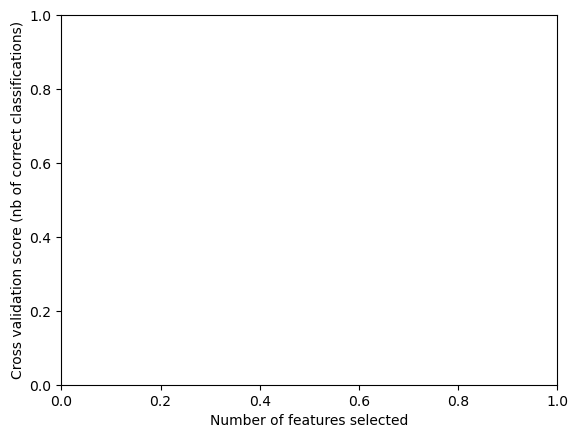

In [11]:
svc=svm.SVC(kernel="linear")
rfecv = RFECV(estimator=svc, 
              step=2, 
              cv=KFold(10), # Stratified fold inorder to reduce bias
              scoring='balanced_accuracy', 
              verbose=3)
rfetrain=rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)


# Plot showing the Cross Validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [24]:
np.array(range(0, 59, 2))

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58])

In [23]:
pd.DataFrame(rfecv.cv_results_)#['mean_test_score']

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score
0,0.303515,0.248027,0.500000,0.500000,0.500000,0.500000,0.500000,0.535153,0.000000,0.000000,0.000000,0.000000
1,0.569728,0.039523,0.540545,0.543586,0.563763,0.573549,0.545588,0.677266,0.577566,0.544153,0.589499,0.541766
2,0.582858,0.086856,0.550212,0.496903,0.565448,0.510268,0.437500,0.757509,0.651551,0.634845,0.630072,0.594272
3,0.579713,0.082077,0.529515,0.479126,0.554049,0.515476,0.464947,0.740888,0.642005,0.634845,0.639618,0.596659
4,0.583865,0.084341,0.502727,0.493677,0.517408,0.520685,0.506425,0.760737,0.649165,0.637232,0.634845,0.615752
5,0.589978,0.091587,0.506727,0.514099,0.531503,0.477790,0.500661,0.760405,0.687351,0.644391,0.661098,0.615752
6,0.590535,0.097852,0.515424,0.518357,0.545597,0.447879,0.485355,0.767434,0.689737,0.653938,0.665871,0.615752
7,0.596853,0.094034,0.540818,0.506162,0.556379,0.459598,0.505149,0.775126,0.689737,0.653938,0.658711,0.622912
8,0.590053,0.100140,0.535485,0.506162,0.510669,0.460900,0.477702,0.769998,0.694511,0.661098,0.663484,0.620525
9,0.599163,0.099383,0.524182,0.537166,0.540824,0.479055,0.462396,0.777358,0.699284,0.670644,0.668258,0.632458


In [16]:
pd.DataFrame(rfecv.cv_results_).index

RangeIndex(start=0, stop=30, step=1)

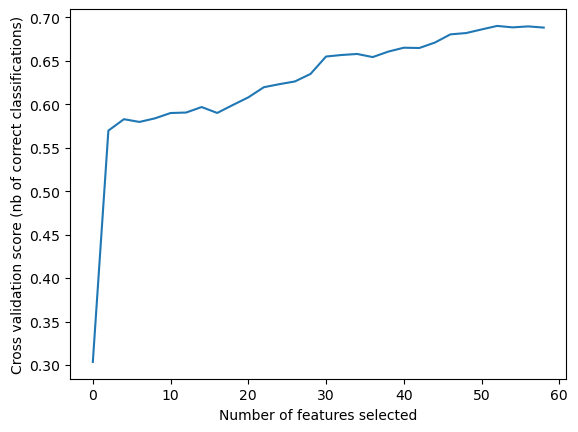

In [25]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(0, 59, 2), pd.DataFrame(rfecv.cv_results_)['mean_test_score'])
plt.show()

In [ ]:
rfecv.grid_scores

AttributeError: 'RFECV' object has no attribute 'grid_scores'

Fitting estimator with 58 features.
Fitting estimator with 28 features.
Fitting estimator with 58 features.
Fitting estimator with 28 features.
Fitting estimator with 58 features.
Fitting estimator with 28 features.
Fitting estimator with 58 features.
Fitting estimator with 28 features.
Fitting estimator with 58 features.
Fitting estimator with 28 features.
Fitting estimator with 58 features.
Fitting estimator with 28 features.
Fitting estimator with 58 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 28 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 58 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 28 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 58 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 28 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 58 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitting estimator with 28 features.


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Optimal number of features : 58


AttributeError: 'RFECV' object has no attribute 'grid_scores_'

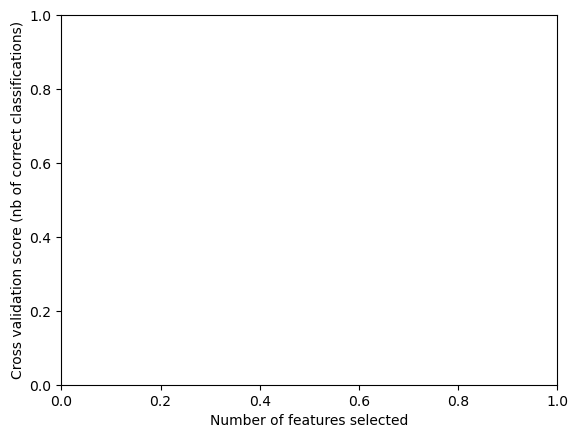

In [10]:
svc=svm.SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=30, cv=KFold(10), # Stratified fold inorder to reduce bias
              scoring='balanced_accuracy', verbose=3)
rfetrain=rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)


# Plot showing the Cross Validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [33]:
svc=svm.SVC(kernel="linear")
rfecv = RFECV(estimator=svc, 
              step=50, 
              cv=KFold(10), # Stratified fold inorder to reduce bias
              scoring='balanced_accuracy', 
              verbose=3)
rfetrain=rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)


# Plot showing the Cross Validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


Fitting estimator with 58 features.
